<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Colab_Notebook_Versions/blob/master/EVA4P1_S15_Comb_FG_Depth_Prediction_V20_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Jun  2 19:31:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    68W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [4]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.58700 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [5]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [6]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 459 (delta 10), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (459/459), 14.90 MiB | 24.88 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [7]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src/losses'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src/losses
Test1.py  Test2.py  Test.py  Train1.py	Train2.py  Train.py


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.losses  import Train1 as Train1
from src.losses  import Test1  as Test1
from src.losses  import Train2 as Train2
from src.losses  import Test2  as Test2
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [4]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small  = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
bs_display= 8
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test data, GT mask & GT depth only 'To Tensor' & 'Resize' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
mask_mean,  mask_stdev                     = [0.20249742], [0.39961225]
depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
#fg_bg_mean, fg_bg_stdev                    = [144.5, 126.9, 111.26], [63.88, 62.94, 65.08]
#mask_mean,  mask_stdev                     = [51.6], [101.9]
#depth_mean, depth_stdev                    = [83.995], [63.57]
#bg_mean, bg_stdev                          = [148.53, 130.74, 111.41], [61.84, 62.01, 64.77]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=bg_mean, std=bg_stdev),])

In [7]:
print(fg_bg_transforms)
print(bg_transforms)
print(mask_transforms)
print(depth_transforms)
print(test_fg_bg_transforms)
print(test_bg_transforms)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f65c50>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f6a588>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f6ae80>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f65e10>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f6a748>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f71080>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f65f60>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f6a898>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f711d0>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f0851f6a0f0>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.
- 0 - 80k    -> size 64x64    
- 80k - 160k -> size 64x64    
- 160k -220k -> size 64x64    
- 220k -260k -> size 96x96    
- 260k -280k -> size 192x192  
- 280k -400k -> size 64x64 -> Test dataset

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, 0, 1000,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, 1000, 2000,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, t160k, t220k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, t220k, t260k,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, t260k, t280k,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, t280k, t400k,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small,  shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large   = DataLoader(train_ds_large,  batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl          = DataLoader(test_ds,         batch_size = bs_test,  shuffle = True, pin_memory = True)

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 399000, 400000,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = bs_display,  shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [11]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
B6: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_mini_1['f3']

In [0]:
def show(tensors, mean, stdev, figsize= (10,10), *args, **kwargs):

  tensor_mean   = mean
  tensor_stdev  = stdev
  for i in range(tensors.shape[0]):
      if tensors.shape[1] ==3:
        for j in range(0,3):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
      if tensors.shape[1] ==1:
        for j in range(0,1):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])

  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

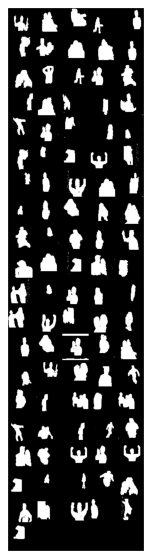

In [20]:
show(imgs, mask_mean, mask_stdev, nrow=rows)

### Initializing the model and assigning it to Cuda

In [11]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

In [0]:
for name, module in model.named_modules():
    print('name:',name)

### Defining Loss Criterion & creating scheduler

In [0]:
criterion1  = nn.BCEWithLogitsLoss()
#criterion1  = DiceLoss()
kernel_size = 3
#criterion1  = SSIM(kernel_size, reduction = 'mean')
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

In [0]:
class Training_loss3: 
    def train_loss_calc(self,model, device, train_loader, optimizer, epoch, criterion1, criterion2, batch_size, path_name,path_model_save,
                        scheduler=None, model_save_idx=500, img_save_idx=500,maxlr=0):
                        
          self.model        = model
          self.device       = device
          self.train_loader = train_loader
          self.optimizer    = optimizer
          self.epoch        = epoch
          self.criterion1   = criterion1
          self.criterion2   = criterion2
          self.scheduler    = scheduler
          self.model_save_idx    = model_save_idx
          self.img_save_idx      = img_save_idx
          self.maxlr        = maxlr
          self.batch_size   = batch_size
          self.path_name    = path_name
          self.path_model_save = path_model_save
        
          model.train()
          train_loss1, train_loss2, train_loss, train_mask_iou_cum, train_depth_iou_cum = 0, 0, 0, 0, 0
          pbar = tqdm(train_loader)
          num_batches = len(train_loader.dataset)/batch_size
          cuda0 = torch.device('cuda:0')
          log_path  = path_name + 'train_log.txt'
          log_file  = open(f'{log_path}', "a")          

          for batch_idx, data in enumerate(pbar):
            data['f1'] = data['f1'].to(cuda0)
            data['f2'] = data['f2'].to(cuda0)
            data['f3'] = data['f3'].to(cuda0)
            data['f4'] = data['f4'].to(cuda0)
            #data['f3O'] = torch.tensor(data['f3'],dtype= torch.int64, device= cuda0)

            optimizer.zero_grad()
            output = model(data)

            print(output[0])
            output_0_unnorm = self.unnorm(output[0], mask_mean,  mask_stdev)
            print(type(output_0_unnorm), output_0_unnorm.shape)
            print(output_0_unnorm)

            #loss1 = criterion1(output[0], data['f3'])
            #loss2 = criterion2(output[1], data['f4'])
            loss1 = criterion1(self.unnorm(output[0], mask_mean,  mask_stdev),  self.unnorm(data['f3'], mask_mean, mask_stdev))
            loss2 = criterion2(self.unnorm(output[1], depth_mean, depth_stdev), self.unnorm(data['f4'], depth_mean, depth_stdev))
            loss  = 2*loss1 + loss2
            train_loss1 += loss1
            train_loss2 += loss2
            train_loss  += loss
            mask_iou   = self.calculate_iou(data['f3'].detach().cpu().numpy(), output[0].detach().cpu().numpy())
            depth_iou  = self.calculate_iou(data['f4'].detach().cpu().numpy(),  output[1].detach().cpu().numpy())
            train_mask_iou_cum  += mask_iou
            train_depth_iou_cum += depth_iou

            pbar.set_description(desc = f'TR{int(epoch)}|{int(batch_idx)}|{loss1:.3f}|{loss2:.3f}|{mask_iou:.3f}|{depth_iou:.3f}') 
                                          
            loss.backward()
            optimizer.step()
            
            if batch_idx % img_save_idx == 0 or batch_idx == int(num_batches-1):
                print('Train Epoch:{} Batch_ID: {} [{}/{} ({:.0f}%)]\tLoss:{:.5f} Mask_Loss:{:.5f} Dpth_Loss:{:.5f} Mask_IOU:{:.5f} Dpth_IOU: {:.5F}'
                      .format(epoch, batch_idx, batch_idx * batch_size, len(train_loader.dataset), (100. * batch_idx / len(train_loader)),
                       loss, loss1, loss2, mask_iou, depth_iou))
                flg = self.draw_and_save(output[0].detach().cpu(),mask_mean, mask_stdev, f'{path_name}{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
                flg = self.draw_and_save(data['f3'].detach().cpu(),mask_mean, mask_stdev, f'{path_name}{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
                flg = self.draw_and_save(output[1].detach().cpu(),depth_mean, depth_stdev, f'{path_name}{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
                flg = self.draw_and_save(data['f4'].detach().cpu(),depth_mean, depth_stdev, f'{path_name}{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
                flg = self.draw_and_save(data['f1'].detach().cpu(), fg_bg_mean, fg_bg_stdev, f'{path_name}{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')
                string = f' Train Epoch-{int(epoch)}|Batch-{int(batch_idx)}|Loss-{loss:.5f}|MaskLoss-{loss1:.5f}|DepthLoss-{loss2:.5f}|MaskIOU-{mask_iou:.5f}|DepthIOU-{depth_iou:.5f}'
                wrt = self.log_write(string, log_file)                
              
            if batch_idx % model_save_idx == 0:
              torch.save(model.state_dict(),path_model_save)
              print('MODEL SAVED:',path_model_save, 'Epoch & Batch-ID:', epoch, batch_idx)
              
          #train_loss       /= len(train_loader.dataset)
          train_loss       /= num_batches
          train_mask_loss   = train_loss1/num_batches
          train_depth_loss  = train_loss2/num_batches
          train_mask_iou    = train_mask_iou_cum/num_batches
          train_depth_iou   = train_depth_iou_cum/num_batches
          string = f'*Train Epoch-{int(epoch)}|Batch-{int(batch_idx)}|Loss-{train_loss:.5f}|MaskLoss-{train_mask_loss:.5f}|DepthLoss-{train_depth_loss:.5f}|MaskIOU-{train_mask_iou:.5f}|DepthIOU-{train_depth_iou:.5f}'
          wrt    = self.log_write(string, log_file)
          log_file.close()          
          return train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou   

    def calculate_iou(self, target, prediction, thresh=0.5):
        '''
        Calculate intersection over union value
        :param target: ground truth
        :param prediction: output predicted by model
        :param thresh: threshold
        :return: iou value
        '''
        intersection = np.logical_and(np.greater(target, thresh), np.greater(prediction, thresh))
        union = np.logical_or(np.greater(target, thresh), np.greater(prediction, thresh))
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score

    def unnorm(self, inp, inp_mean, inp_stdev):
        try:
            tensors = inp.detach().cpu()
        except:
            pass

        for i in range(inp.shape[0]):
            if inp.shape[1] ==3:
               for j in range(0,3):  
                     inp[i,j] = ((inp[i,j] * inp_stdev[j]) + inp_mean[j])
            if inp.shape[1] ==1:
                for j in range(0,1):  
                     inp[i,j] = ((inp[i,j] * inp_stdev[j]) + inp_mean[j])     
        return inp

    def draw_and_save(self, tensors, mean, stdev, name, figsize=(15,15), *args, **kwargs):
          try:
            tensors = tensors.detach().cpu()
          except:
            pass
            
          tensor_mean   = mean
          tensor_stdev  = stdev
          for i in range(tensors.shape[0]):
              if tensors.shape[1] ==3:
                 for j in range(0,3):  
                     tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
              if tensors.shape[1] ==1:
                 for j in range(0,1):  
                     tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])              
            
          grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
          grid_image  = grid_tensor.permute(1, 2, 0)
          plt.figure(figsize = figsize)
          plt.imshow(grid_image)
          plt.xticks([])
          plt.yticks([])

          plt.savefig(name, bbox_inches='tight')
          plt.close()
          flag = True
         #plt.show()
          return flag    

    def log_write(self, string, log_file):
          wrt = False
          write_str = string + '\n'
          log_file.write(write_str)
          wrt = True
          return wrt      

In [0]:
class Testing_loss3:

      def test_loss_calc(self,model, device, test_loader, optimizer, epoch, criterion1, criterion2, batch_size, path_name, scheduler=None, img_save_idx =500):
          self.model        = model
          self.device       = device
          self.test_loader  = test_loader
          self.optimizer    = optimizer
          self.epoch        = epoch
          self.criterion1   = criterion1
          self.criterion1   = criterion2           
          self.scheduler    = scheduler
          self.batch_size   = batch_size
          self.path_name    = path_name
          self.img_save_idx = img_save_idx

          model.eval()  
          test_loss1, test_loss2, test_loss, test_mask_iou_cum, test_depth_iou_cum = 0, 0, 0, 0, 0
          pbar = tqdm(test_loader)
          num_batches = len(test_loader.dataset)/batch_size
          cuda0 = torch.device('cuda:0')
          log_path  = path_name + 'test_log.txt'
          log_file  = open(f'{log_path}', "a")

          with torch.no_grad():
            for batch_idx, data in enumerate(pbar):
              data['f1'] = data['f1'].to(cuda0)
              data['f2'] = data['f2'].to(cuda0)
              data['f3'] = data['f3'].to(cuda0)
              data['f4'] = data['f4'].to(cuda0)      
              #data['f3O'] = torch.tensor(data['f3'],dtype= torch.int64, device= cuda0)      
            
              output = model(data)

              loss1 = criterion1(output[0], data['f3'])
              loss2 = criterion2(output[1], data['f4'])
              loss  = 2*loss1 + loss2
              test_loss1 += loss1
              test_loss2 += loss2
              test_loss  += loss
              mask_iou   = self.calculate_iou(data['f3'].detach().cpu().numpy(), output[0].detach().cpu().numpy())
              depth_iou  = self.calculate_iou(data['f4'].detach().cpu().numpy(),  output[1].detach().cpu().numpy())
              test_mask_iou_cum  += mask_iou
              test_depth_iou_cum += depth_iou

              pbar.set_description(desc = f'TS{int(epoch)}|{int(batch_idx)}|{loss1:.3f}|{loss2:.3f}|{mask_iou:.3f}|{depth_iou:.3f}')   
              
              if batch_idx % img_save_idx == 0 or batch_idx == int(num_batches-1):
                  print('Test Epoch: {} [{}/{} ({:.0f}%)]\tTest_Loss: {:.6f} Mask_Loss: {:.5f} Dpth_Loss: {:.5f} Mask_IOU: {:.5f} Dpth_IOU: {:.5F}'
                         .format(epoch, batch_idx * len(data), len(test_loader.dataset), (100. * batch_idx / len(test_loader)),
                                 loss.item(), loss1.item(), loss2.item(),mask_iou, depth_iou ))
                  flg = self.draw_and_save(output[0].detach().cpu(),mask_mean, mask_stdev, f'{path_name}Test_{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
                  flg = self.draw_and_save(data['f3'].detach().cpu(),mask_mean, mask_stdev, f'{path_name}Test_{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
                  flg = self.draw_and_save(output[1].detach().cpu(),depth_mean, depth_stdev, f'{path_name}Test_{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
                  flg = self.draw_and_save(data['f4'].detach().cpu(),depth_mean, depth_stdev, f'{path_name}Test_{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
                  flg = self.draw_and_save(data['f1'].detach().cpu(), fg_bg_mean, fg_bg_stdev, f'{path_name}Test_{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')
                  string = f' Test Epoch-{int(epoch)}|Batch-{int(batch_idx)}|Loss-{loss:.5f}|MaskLoss-{loss1:.5f}|DepthLoss-{loss2:.5f}|MaskIOU-{mask_iou:.5f}|DepthIOU-{depth_iou:.5f}'
                  wrt = self.log_write(string, log_file)
            
          #test_loss      /= len(test_loader.dataset)
          test_loss      /= num_batches
          test_mask_loss  = test_loss1/num_batches
          test_depth_loss = test_loss2/num_batches
          test_mask_iou   = test_mask_iou_cum/num_batches
          test_depth_iou  = test_depth_iou_cum/num_batches
          string = f'*Test Epoch-{int(epoch)}|Batch-{int(batch_idx)}|Loss-{test_loss:.5f}|MaskLoss-{test_mask_loss:.5f}|DepthLoss-{test_depth_loss:.5f}|MaskIOU-{test_mask_iou:.5f}|DepthIOU-{test_depth_iou:.5f}'
          wrt    = self.log_write(string, log_file)
          log_file.close()
          return test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou

      def calculate_iou(self, target, prediction, thresh=0.5):
        '''
        Calculate intersection over union value
        :param target: ground truth
        :param prediction: output predicted by model
        :param thresh: threshold
        :return: iou value
        '''
        intersection = np.logical_and(np.greater(target, thresh), np.greater(prediction, thresh))
        union = np.logical_or(np.greater(target, thresh), np.greater(prediction, thresh))
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score
        
      def draw_and_save(self, tensors, mean, stdev, name, figsize=(15,15), *args, **kwargs):
          try:
            tensors = tensors.detach().cpu()
          except:
            pass
            
          tensor_mean   = mean
          tensor_stdev  = stdev
          for i in range(tensors.shape[0]):
              if tensors.shape[1] ==3:
                 for j in range(0,3):  
                     tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
              if tensors.shape[1] ==1:
                 for j in range(0,1):  
                     tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])            
            
          grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
          grid_image  = grid_tensor.permute(1, 2, 0)
          plt.figure(figsize = figsize)
          plt.imshow(grid_image)
          plt.xticks([])
          plt.yticks([])

          plt.savefig(name, bbox_inches='tight')
          plt.close()
          flag = True
         #plt.show()
          return flag

      def log_write(self, string, log_file):
          wrt = False
          write_str = string + '\n'
          log_file.write(write_str)
          wrt = True
          return wrt          

### Defining train & test loss classes

In [0]:
#train_loss_fn = Train2.Training_loss1()
#test_loss_fn  = Test2.Testing_loss1()

In [0]:
train_loss_fn = Training_loss3()
test_loss_fn  = Testing_loss3()

### Reloading model from last saved weights that are present in gdrive

In [17]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0602_V20C/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [19]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,3):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs_small, train_dl_mini_1
     #freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs_small, train_dl_mini_2
     #freezer.freeze_depth_layers(model)   
  elif epoch < 4:
     batch_size, loader = bs_small,  train_dl_mini_1
     freezer.freeze_depth_layers(model)
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model)   

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs_display, test_dl_display
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

tensor([[[[-1.3732, -2.2953, -2.0001,  ..., -4.1513, -3.8886, -2.9711],
          [-2.8223, -4.1979, -3.9481,  ..., -5.8469, -5.4748, -4.3784],
          [-3.3912, -4.4097, -3.7275,  ..., -6.3225, -6.0292, -4.8761],
          ...,
          [-2.3135, -4.0611, -3.8880,  ..., -6.9179, -6.6722, -4.9549],
          [-2.1102, -2.9890, -2.6875,  ..., -5.5912, -5.2691, -4.1541],
          [-0.9691, -1.5727, -1.3869,  ..., -4.2423, -3.8648, -2.9100]]],


        [[[-1.6655, -2.8855, -2.3322,  ..., -2.0722, -2.5732, -1.7366],
          [-2.1584, -2.9928, -2.2915,  ..., -3.3899, -3.9837, -2.5497],
          [-2.7009, -3.0503, -2.0494,  ..., -4.5941, -4.3453, -2.7808],
          ...,
          [-0.7328, -0.9745, -0.8234,  ..., -4.5596, -5.0164, -4.2910],
          [-0.3943, -0.0184, -0.0878,  ..., -3.2487, -3.8700, -3.3137],
          [ 0.2553,  0.4856,  0.5417,  ..., -2.3868, -2.6012, -2.2669]]],


        [[[-1.2338, -1.8244, -1.5186,  ..., -1.8845, -1.4818, -0.9712],
          [-2.0361, -2.358

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/1000 (0%)]	Loss:1.14846 Mask_Loss:0.47505 Dpth_Loss:0.19836 Mask_IOU:0.53164 Dpth_IOU: 0.22212
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt Epoch & Batch-ID: 1 0
tensor([[[[ -2.5444,  -5.1466,  -5.6890,  ...,  -4.5700,  -3.9487,  -2.5325],
          [ -3.7030,  -7.2216,  -7.5290,  ...,  -6.4968,  -5.7958,  -4.0441],
          [ -4.3657,  -7.6422,  -7.7551,  ...,  -6.7520,  -6.3188,  -4.5365],
          ...,
          [ -2.8884,  -4.7499,  -5.1153,  ...,  -6.0478,  -6.2960,  -4.0278],
          [ -3.1627,  -4.3082,  -5.0707,  ...,  -4.9719,  -4.7069,  -2.6253],
          [ -2.6118,  -3.9067,  -4.5427,  ...,  -3.3624,  -3.2014,  -1.9388]]],


        [[[ -1.6766,  -3.8542,  -3.9952,  ...,  -5.3165,  -4.6950,  -3.2971],
          [ -2.9436,  -6.3868,  -6.5296,  ...,  -8.3215,  -7.4153,  -5.2742],
          [ -3.9080,  -7.5434,  -7.6379,  ...,  -9.5635,  -8.5029,  -6.0622],
          ...,
          [ -3.9232,  -7.0146,  -7.9065,  ..., -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 9 [864/1000 (82%)]	Loss:0.73213 Mask_Loss:0.26840 Dpth_Loss:0.19533 Mask_IOU:0.31996 Dpth_IOU: 0.46064
tensor([[[[ -2.5873,  -4.3719,  -4.4410,  ...,  -7.4987,  -7.1174,  -4.6219],
          [ -4.4950,  -7.3091,  -8.0760,  ..., -11.3600, -10.5525,  -6.6289],
          [ -5.0348,  -7.5143,  -8.6966,  ..., -11.2588, -10.0747,  -6.3188],
          ...,
          [-24.8441, -40.0845, -48.6571,  ..., -45.3899, -38.8256, -25.0280],
          [-20.9275, -33.9467, -42.0413,  ..., -38.8692, -32.8387, -20.9643],
          [-12.8464, -20.9563, -26.1156,  ..., -25.5250, -21.3107, -13.4737]]],


        [[[-11.5878, -18.2902, -20.5178,  ..., -25.4519, -21.8570, -13.8864],
          [-19.7435, -30.1244, -34.0381,  ..., -40.1685, -34.4069, -21.4325],
          [-24.6811, -37.1163, -42.4370,  ..., -47.8746, -40.9331, -25.7007],
          ...,
          [-25.0916, -38.9238, -44.2501,  ..., -45.7202, -37.4760, -23.1728],
          [-21.9540, -33.3992, -37.9080,  ..., -37.6280, -3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/1000 (0%)]	Test_Loss: -21.335037 Mask_Loss: -10.87249 Dpth_Loss: 0.40994 Mask_IOU: 0.52999 Dpth_IOU: 0.53508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [496/1000 (99%)]	Test_Loss: -31.470831 Mask_Loss: -15.93649 Dpth_Loss: 0.40216 Mask_IOU: 0.62310 Dpth_IOU: 0.56508



tensor([[[[-16.1238, -26.7239, -31.0875,  ..., -30.7183, -26.4903, -17.0166],
          [-26.3630, -42.3578, -49.3062,  ..., -50.0462, -42.7360, -27.0541],
          [-30.7882, -48.3771, -56.4412,  ..., -59.9838, -51.1341, -32.5905],
          ...,
          [-23.5648, -38.5084, -45.4955,  ..., -32.1570, -27.5462, -17.8170],
          [-19.9499, -31.8034, -37.7098,  ..., -26.1280, -22.1564, -14.2759],
          [-13.2631, -20.2734, -23.3952,  ..., -15.9777, -13.2169,  -8.6453]]],


        [[[-14.5213, -24.8542, -29.9284,  ..., -25.8121, -21.5578, -13.3537],
          [-24.0986, -40.8942, -49.2512,  ..., -42.1979, -34.9661, -21.2340],
          [-29.5642, -49.3085, -59.3325,  ..., -46.9949, -39.5637, -24.6786],
          ...,
          [-23.7237, -38.8607, -45.6172,  ..., -36.6453, -31.8367, -21.6699],
          [-19.0248, -30.9538, -36.7712,  ..., -29.6843, -25.8398, -17.6268],
          [-12.6552, -19.8572, -23.0308,  ..., -18.3538, -16.0709, -10.8520]]],


        [[[-13.3591, -21.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/1000 (0%)]	Loss:0.76871 Mask_Loss:0.28015 Dpth_Loss:0.20840 Mask_IOU:0.36845 Dpth_IOU: 0.47621
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt Epoch & Batch-ID: 2 0
tensor([[[[-10.5410, -16.9520, -19.0440,  ...,  -4.2797,  -5.3434,  -3.0419],
          [-16.6883, -25.6845, -28.9441,  ...,  -7.9706,  -8.5886,  -5.0852],
          [-19.3143, -29.1775, -32.7362,  ...,  -8.7077,  -9.4543,  -5.4286],
          ...,
          [-12.9102, -17.7856, -17.5670,  ..., -20.9935, -19.7224, -14.2152],
          [-11.3967, -15.9093, -15.3596,  ..., -18.7372, -17.2312, -12.3965],
          [ -7.5525,  -9.7323,  -9.0167,  ..., -12.8646, -11.6082,  -8.0528]]],


        [[[-15.3517, -26.6181, -31.6051,  ..., -29.2472, -24.4936, -15.9710],
          [-24.1653, -40.7651, -47.7347,  ..., -45.0084, -37.5912, -24.2095],
          [-28.4471, -46.8853, -54.7084,  ..., -52.7526, -44.2092, -28.4914],
          ...,
          [-24.3524, -38.0607, -43.0536,  ..., -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 9 [864/1000 (82%)]	Loss:0.72247 Mask_Loss:0.26321 Dpth_Loss:0.19604 Mask_IOU:0.52887 Dpth_IOU: 0.52704
tensor([[[[-14.5848, -24.4700, -28.3216,  ..., -24.1655, -22.4382, -14.3138],
          [-23.4389, -37.9819, -43.8542,  ..., -40.8621, -36.3174, -22.5429],
          [-27.7123, -43.9732, -50.5788,  ..., -48.0884, -41.9899, -25.5244],
          ...,
          [-28.3049, -46.5502, -56.0371,  ..., -61.6131, -55.2174, -37.5124],
          [-24.0549, -38.0998, -45.0503,  ..., -50.4139, -44.4329, -29.9268],
          [-15.5747, -23.3275, -27.6309,  ..., -32.1045, -27.9057, -18.2131]]],


        [[[-17.4536, -28.3716, -32.5110,  ..., -34.1629, -30.2730, -20.3085],
          [-28.7574, -46.5272, -53.9100,  ..., -54.7962, -47.3603, -30.6238],
          [-35.5540, -55.9734, -65.5954,  ..., -63.6126, -55.8152, -34.9687],
          ...,
          [-28.3235, -41.6609, -44.2361,  ..., -36.6044, -34.7909, -24.5398],
          [-22.4109, -32.5664, -35.4910,  ..., -29.9341, -2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/1000 (0%)]	Test_Loss: -28.091272 Mask_Loss: -14.25347 Dpth_Loss: 0.41566 Mask_IOU: 0.70394 Dpth_IOU: 0.57904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [496/1000 (99%)]	Test_Loss: -40.296303 Mask_Loss: -20.35792 Dpth_Loss: 0.41953 Mask_IOU: 0.66158 Dpth_IOU: 0.61137



In [89]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [-4.159636974334717, -4.148824214935303, -4.155249118804932, -4.153412818908691]
train_mask_loss_all: [-2.2977609634399414, -2.2922563552856445, -2.295564651489258, -2.2945377826690674]
train_depth_loss_all: [0.43588024377822876, 0.435686856508255, 0.4358852207660675, 0.4356670677661896]
train_mask_iou_all: [0.6292602989141174, 0.6286894187105521, 0.6295407916091085, 0.6290288922100892]
train_depth_iou_all: [0.5577884122360176, 0.5576522196536642, 0.5582173312653131, 0.5578119549377145]
test_loss_all: [-5.3766398429870605, -5.371697425842285, -5.369205951690674, -5.400627613067627]
test_mask_loss_all: [-2.9046266078948975, -2.901961326599121, -2.900749921798706, -2.9164798259735107]
test_depth_loss_all: [0.4325992465019226, 0.43223944306373596, 0.4322819113731384, 0.43234071135520935]
test_mask_iou_all: [0.7284955093990308, 0.7241481586978028, 0.7226227124640627, 0.7227196143794844]
test_depth_iou_all: [0.5941983240699237, 0.5932396621107622, 0.6001247996647006, 0.59467

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 390000, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = 8,  shuffle = True, pin_memory = True)
batch_size, loader = 8, test_dl_display
epoch = 11
test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)